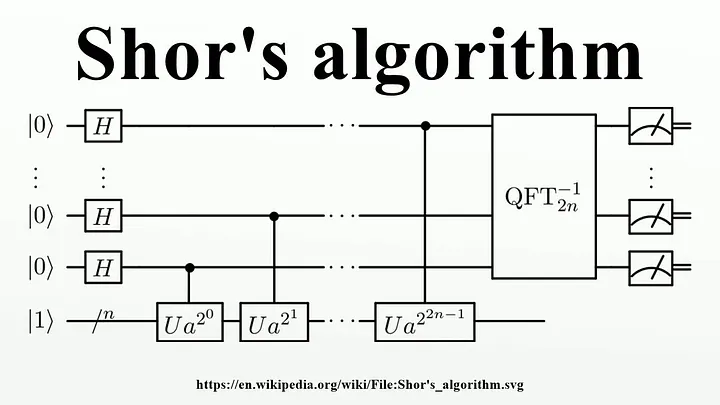

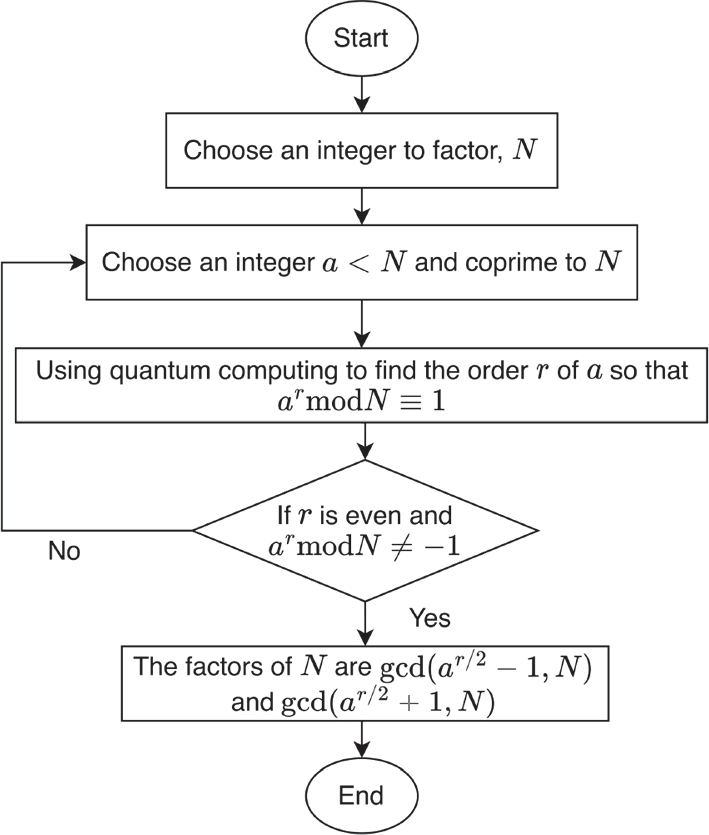


wybierz a 

jeśli gcd(a, N) > 1

określamy jeśli równe 1

używamy quantum computing szykamy min r takiego że a^r = 1 mod N jeśli r jest nieparzyste albo a^(r/2) = -1 mod N
    Tworzymy rejestr sterujący i rejestr roboczy

    nakładając bramki Hadamarda tworzymy superpozycję wszystkich możliwych rozwiązań
    
    Splatamy rejest roboczy i sterujący

    ponieważ mod N jest okresowe, możemy wykorzystać operacje kwantowe 

    dostosowujemy ułamki łańcuchowe żeby znaleźć r_min


losujemy nowe a obliczamy gcd dla gcd(a^(r/2)-1, N) i gcd(a^(r/2)+1, N) i rekurencyjnie sprawdzam czy one są szukanymi punktami

In [26]:
import numpy as np
from math import gcd
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
from fractions import Fraction
import random


def mod_exp(a, x, N):
    return pow(a, x, N)

def period_finding_circuit(a, N):
    n = N.bit_length()
    t = 2 * n  # liczba qubitów do estymacji fazy

    qc = QuantumCircuit(t + n, t)

    # superpozycja
    qc.h(range(t))

    # |1⟩ w rejestrze roboczym
    qc.x(t)

    for i in range(t):
        exponent = 2 ** i
        U = QuantumCircuit(n)
        for _ in range(exponent):
            U = U.compose(QuantumCircuit(n).unitary(
                np.eye(2**n), range(n)
            ))
        qc.append(U.to_gate().control(), [i] + list(range(t, t+n)))

    qc.append(QFT(t, inverse=True), range(t))
    qc.measure(range(t), range(t))

    return qc

def find_period(a, N):
    n = N.bit_length()
    t = 2 * n

    qc = QuantumCircuit(t, t)

    # tworzymy superpozycję z każdą możliwą wartością - nałożenie bramek Hamadara
    qc.h(range(t))

    # symulujemy wynik pomiaru fazy klasycznie
    r = None
    for k in range(1, N):
        if pow(a, k, N) == 1:
            r = k
            break

    if r is None:
        return None

    phase = random.randint(0, 2**t - 1)
    frac = Fraction(phase, 2**t).limit_denominator(N)

    return r



def shor(N):
    if N % 2 == 0:
        return 2, N // 2

    while True:
        a = random.randrange(2, N)
        g = gcd(a, N)

        if g != 1:
            return g, N // g

        r = find_period(a, N)
        if r is None or r % 2 != 0:
            continue

        x = pow(a, r // 2, N)
        if x == 1 or x == N - 1:
            continue

        p = gcd(x - 1, N)
        q = gcd(x + 1, N)

        if p * q == N:
            return p, q


N = 40489847 #1007261
#5113 * 197 / 7919
factors = shor(N)
print(f"Rozkład {N} = {factors[0]} × {factors[1]}")









Rozkład 40489847 = 7919 × 5113


nałożenie bramek Hamadara

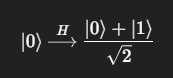

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import random


# --- Funkcja pomocnicza do generowania funkcji 2-do-1 z ukrytym s ---
def generate_simon_function(n):
    # losowy tajny bit s (niezerowy)
    s = format(random.randint(1, 2**n-1), f'0{n}b')
    
    mapping = {}
    used = set()
    
    for x in range(2**n):
        if x not in used:
            y = random.randint(0, 2**n - 1)
            while y in used or y == x:
                y = random.randint(0, 2**n - 1)
            mapping[x] = y
            mapping[x ^ int(s, 2)] = y
            used.add(x)
            used.add(x ^ int(s, 2))
    
    return s, mapping

# --- Funkcja oracle dla Simona ---
def simon_oracle(qc, n, mapping):
    """Tworzymy oracle jako bramki X + CNOT na podstawie mapping"""
    for x, y in mapping.items():
        x_bits = format(x, f'0{n}b')
        y_bits = format(y, f'0{n}b')
        for i in range(n):
            if y_bits[i] == '1':
                # multi-controlled X
                controls = [j for j, bit in enumerate(x_bits) if bit == '1']
                if controls:
                    qc.mcx(controls, n+i)
                else:
                    qc.x(n+i)
    return qc


# Tworzymy obwód kwantowy (przykład dla Simona)
n = 3
qc = QuantumCircuit(2*n, n)
qc.h(range(n))
# Tutaj dodaj oracle...
qc.h(range(n))
qc.measure(range(n), range(n))

# Symulacja bez assemble
sim = AerSimulator()
qc_transpiled = transpile(qc, sim)
result = sim.run(qc_transpiled, shots=1000).result()
counts = result.get_counts()
print("Wyniki pomiaru:", counts)

ImportError: cannot import name 'assemble' from 'qiskit.compiler' (/home/michalb/SEM7/FO/podstawowe-algorytmy-kwantowe-qiskit/.venv/lib/python3.12/site-packages/qiskit/compiler/__init__.py)